Name: Seyed Morteza Hosseini\
This is my solution for Thomson Reuters data science challeng\
Here I answer to the questions of the challenge, then the code starts

1. There are multiple things that can be addressed for a solution to this problem
   * Text Classification with Traditional ML Algorithms: We can start with traditional algorithms such as Naive Bayes, SVM, or Random Forests as a baseline. We can use TF-IDF to convert text to a vector format that the algorithms can process.
   * Deep Learning with Word Embeddings: We can use word embeddings like Word2Vec, GloVe, or fastText with neural networks like RNNs to capture semantic meaning better than the traditional models. This approach could potentially lead to better performance if the dataset is large enough.
   * Transfer Learning with Pre-trained LMs: Utilizing NLP models like BERT, GPT, or RoBERTa that have been pre-trained on large corpuses of text can be highly effective. These models can be fine-tuned on the specific dataset of customer queries to achieve high accuracy. This is a part of the sulotion that I used in this notebook.
   * Ensemble Methods: Combining multiple models can often lead to better performance than any single model. An ensemble could average the predictions from a variety of models or use more sophisticated methods like stacking. For example we can use multiple types of models such as different flavour of BERTS and ensemble them together.
   * Data Augmentation: To enhance the dataset size and variability, techniques like synonym replacement, back-translation, or generative models could be employed to create additional training data. I used synonym replacement to expand my train data, with a very simple method.

2. The implementation comes after the answers

3. Metrics reported down bellow, I wanted to have multiple metrics for different changes that I made to the model, but due to the lack of time I only report the latest that I get.

4. The current performance is good ~90%, the business can use this as a even a user facing model, this can lower the call center queries. If the model performance was worse ~60% I would suggest that the business donnot put it infront of the user directly, and put a couple of humans in the loop to refine the model 

5. For this type of the problems (text), data is very important, when I populated train data with synonym generated data it enhanced the performance, so I would gather the data from as many sources as I can. Other types of data generation like with an LLM could be useful, but we have to watch out for model helucination and miss classifications. Also if I had time, I would definately try ensembling method, as they tend to increase the performance and decrease the variance and pervent overfitting in these type of problems. Next steps would be adding infrastructure for hyperparameter tuning.

# Imports

In [1]:
import re

import pandas as pd
import numpy as np

import torch

import evaluate
from transformers import AutoTokenizer, DataCollatorWithPadding,  AutoModelForSequenceClassification, TrainingArguments, Trainer
import datasets

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet

nltk.download('stopwords')
nltk.download('wordnet')

TEST_SPLIT = 0.3

2024-03-08 02:07:26.084878: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 02:07:26.122030: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 02:07:26.122054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 02:07:26.123250: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 02:07:26.129738: I tensorflow/core/platform/cpu_feature_guar

# Preprocessors

In [2]:
def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            if word != l.name():
                synonyms.append(l.name())
    return synonyms

def find_synonym(text):
    sentences = [text]
    texts = text.split()
    texts = texts[:len(texts) // 2]
    word_bag = [i for i in texts if i not in stopwords.words('english') and any(map(str.isupper, i)) is False]
    word_bag = list(set(word_bag))
    n = 2  #  each generated text will have two words replaced with their respective synonym 
    combined_bag = [word_bag[i * n:(i + 1) * n] for i in range((len(word_bag) + n - 1) // n)]
    to_exchange = combined_bag
    payload = text
    for words in to_exchange:
        for word in words:
            similar_words = get_synonyms(word)
            if similar_words is not None:
                similar_words = [re.sub('[^A-Za-z ]+', ' ', sent) for sent in similar_words]
                for similar in similar_words:
                    payload = re.sub(word, similar, payload)
                sentences.append(payload)
    sentences = list(set(sentences))
    return sentences

In [3]:
remove_stop = lambda text: ' '.join([word for word in text.split() if word not in stopwords.words('english')])

## We can see the dataset is fairly balanced among labels

array([[<Axes: title={'center': 'label'}>]], dtype=object)

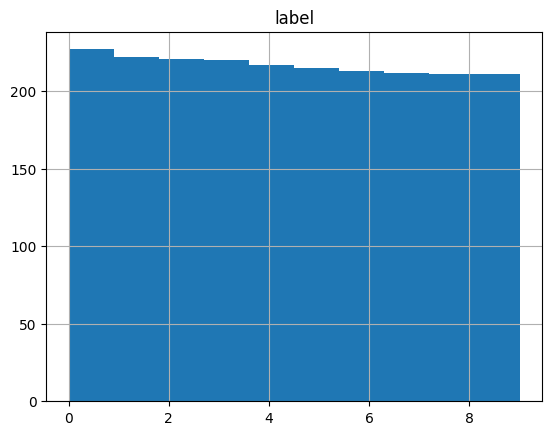

In [4]:
dataset_csv = pd.read_csv("./ds_task_dataset.csv")
dataset_csv.hist()

In [5]:
id2label = {
    0: "CARD_PAYMENT_FEE_CHARGED", 
    1: "DIRECT_DEBIT_PAYMENT_NOT_RECOGNISED",
    2: "BALANCE_NOT_UPDATED_AFTER_CHEQUE_OR_CASH_DEPOSIT",
    3: "WRONG_AMOUNT_OF_CASH_RECEIVED",
    4: "CASH_WITHDRAWAL_CHARGE",
    5: "TRANSACTION_CHARGED_TWICE",
    6: "DECLINED_CASH_WITHDRAWAL",
    7: "TRANSFER_FEE_CHARGED",
    8: "TRANSFER_NOT_RECEIVED_BY_RECIPIENT",
    9: "BALANCE_NOT_UPDATED_AFTER_BANK_TRANSFER",
}
label2id = {v: k for k, v in id2label.items()}

In [6]:
def load_bank_ds(split=TEST_SPLIT):
    dataset = datasets.Dataset.from_pandas(dataset_csv).train_test_split(test_size=split)
    ds = dataset["train"].to_pandas()
    ds["text"] = ds["text"].apply(find_synonym)
    ds = ds.explode('text')
    ds = ds.reset_index(drop=True)
    dataset["train"] = datasets.Dataset.from_pandas(ds)
    return dataset

In [7]:
def get_model(model_name, num_labels=10, id2label=id2label, label2id=label2id):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=10, id2label=id2label, label2id=label2id
    )
    return model, tokenizer

In [8]:
def preprocess_function(examples):
    examples["text"] = list(map(lambda text: remove_stop(text), examples["text"]))
    return tokenizer(examples["text"], truncation=True)

def prepropcess_datasets(fn, *datasets):
    return [ds.map(fn, batched=True) for ds in datasets]

In [9]:
def get_compute_metrics():
    accuracy = evaluate.load("accuracy")
    recall = evaluate.load("recall")
    f1 = evaluate.load("f1")
    metrics = {"accuracy": (accuracy, {}), "recall": (recall, {"average": "micro"}), "f1": (f1, {"average": "micro"})}
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        return {name: metric.compute(predictions=predictions, references=labels, **arg) for name, (metric, arg) in metrics.items()}
    return compute_metrics

In [10]:
dataset = load_bank_ds()
model, tokenizer = get_model("roberta-base")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
tokenized_ds = prepropcess_datasets(preprocess_function, dataset)[0]

Map:   0%|          | 0/5014 [00:00<?, ? examples/s]

Map:   0%|          | 0/651 [00:00<?, ? examples/s]

In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
compute_metrics = get_compute_metrics()

def train_model(model, tokenizer, train_ds, test_ds):
    training_args = TrainingArguments(
        output_dir="text-tagger",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        report_to="none"
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    return trainer.evaluate(test_ds)

In [13]:
def inference(model, texts):
    inputs = tokenizer(texts, return_tensors='pt')
    model = model.cpu()
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    return model.config.id2label[predicted_class_id]

### The result is pretty good, The data generation helped alot

In [14]:
result = train_model(model, tokenizer, tokenized_ds["train"], tokenized_ds["test"])
print(result)

Epoch,Training Loss,Validation Loss,Accuracy,Recall,F1
1,No log,0.236817,{'accuracy': 0.9370199692780338},{'recall': 0.9370199692780338},{'f1': 0.9370199692780338}
2,No log,0.252694,{'accuracy': 0.9354838709677419},{'recall': 0.9354838709677419},{'f1': 0.9354838709677419}
3,No log,0.241315,{'accuracy': 0.9431643625192012},{'recall': 0.9431643625192012},{'f1': 0.9431643625192012}
4,0.393100,0.250815,{'accuracy': 0.9431643625192012},{'recall': 0.9431643625192012},{'f1': 0.9431643625192012}
5,0.393100,0.244936,{'accuracy': 0.9493087557603687},{'recall': 0.9493087557603687},{'f1': 0.9493087557603687}


Checkpoint destination directory text-tagger/checkpoint-157 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.23681682348251343, 'eval_accuracy': {'accuracy': 0.9370199692780338}, 'eval_recall': {'recall': 0.9370199692780338}, 'eval_f1': {'f1': 0.9370199692780338}, 'eval_runtime': 0.493, 'eval_samples_per_second': 1320.563, 'eval_steps_per_second': 42.599, 'epoch': 5.0}


### Lets try the model

In [17]:
print("TEXT: ", tokenized_ds["test"][0]['text'], "TRUE LABEL: ", id2label[tokenized_ds["test"][0]['label']], "PREDICTED LABEL: ", inference(model, tokenized_ds["test"][0]['text']))

TEXT:  After transfering money balance changed. TRUE LABEL:  BALANCE_NOT_UPDATED_AFTER_BANK_TRANSFER PREDICTED LABEL:  BALANCE_NOT_UPDATED_AFTER_BANK_TRANSFER
